# Notebook for generating all an only the figures related to the paper!

## General setup

### Figure path

In [1]:
PATH="../PAPER_DIFFUSION/figs/"
DPI=600

In [2]:
%matplotlib inline

### Libraries

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import scipy.integrate
import scipy.interpolate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import os
# For parallelization
from joblib import Parallel, delayed

import lmfit
import nekhoroshev_tools as nt

In [4]:
from uncertainties import ufloat

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

### Test for the path

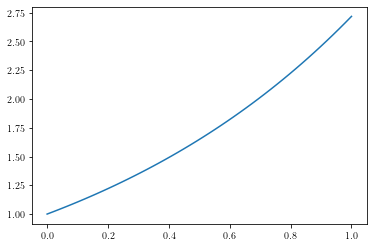

In [6]:
plt.figure()
plt.plot(np.linspace(0, 1), np.exp(np.linspace(0, 1)))

plt.savefig(os.path.join(PATH+"test.pdf"), dpi=DPI)

## Model presentation

### Just the diffusion coefficient

In [7]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)
k_low = 0.20
exponent_low = 1/(k_low*2)
k_high = 0.50
exponent_high = 1/(k_high*2)

In [8]:
I0 = np.ones(1000)
I0[-100:] = 0
engine1 = cn.cn_generic(0, 1.5, I0, 0.001, lambda x : nt.D(x, 1, 1/k, 1.0, True), False)
engine2 = cn.cn_generic(0, 1.5, I0, 0.001, lambda x : nt.D(x, 1, 1/k_low, 1.0, True), False)
engine3 = cn.cn_generic(0, 1.5, I0, 0.001, lambda x : nt.D(x, 1, 1/k_high, 1.0, True), False)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


In [9]:
engine1.reset()
engine2.reset()
engine3.reset()
data0 = engine1.get_data_with_x()
engine1.iterate(10000)
engine2.iterate(10000)
engine3.iterate(10000)
data1 = engine1.get_data_with_x()
data2 = engine2.get_data_with_x()
data3 = engine3.get_data_with_x()

In [10]:
time = 0.001 * 10000

In [11]:
I = np.linspace(0.01, 1.5, 1000)

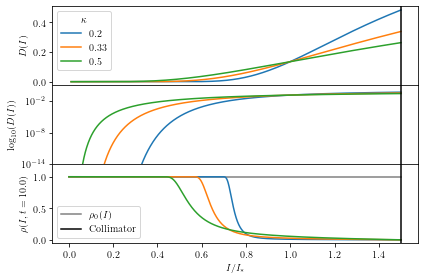

In [12]:
fig = plt.figure()#(figsize=(5, 3))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)

ax0.plot(I, nt.D(I, I_star, exponent_low), label=str(k_low))
ax1.plot(I, nt.D(I, I_star, exponent_low))
ax0.plot(I, nt.D(I, I_star, exponent), label=str(k))
ax1.plot(I, nt.D(I, I_star, exponent))
ax0.plot(I, nt.D(I, I_star, exponent_high), label=str(k_high))
ax1.plot(I, nt.D(I, I_star, exponent_high))

ax2.plot(data1[0], np.ones_like(data1[0]), c="grey", label="$\\rho_0(I)$")
ax2.plot(data1[0], data2[1])
ax2.plot(data1[0], data1[1])
ax2.plot(data1[0], data3[1])

#ax0.axvline(I_star, c="red")
#ax1.axvline(I_star, c="red")
#ax2.axvline(I_star, c="red", label="$I/I_*=1$")

ax0.axvline(1.5, c="black")
ax1.axvline(1.5, c="black")
ax2.axvline(1.5, c="black", label="Collimator")

ax0.legend(title="$\\kappa$")
ax2.legend(loc="lower left")

ax1.set_yscale("log")
ax1.set_ylim(bottom=1e-14, top=10)

plt.setp(ax0.get_xticklabels(), visible=False)

ax2.set_xlabel("$I/I_\\ast$")
ax0.set_ylabel("$D(I)$")
ax1.set_ylabel("$\\log_{10}(D(I))$")
ax2.set_ylabel("$\\rho(I, t={})$".format(time))
ax2.set_ylim(top=1.2)

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-3].label1.set_visible(False)

plt.savefig(os.path.join(PATH+"diffusion_coefficient.pdf"), dpi=DPI)

## Semi-stationary

In [13]:
idx = np.argmin(data1[1]> 0.9) - 1

def stat_f(I, alpha):
    return [alpha * scipy.integrate.quad(
        lambda x: 1/nt.D(x, 1, 1/k, 1.0),
        i, 1.5
    )[0] for i in I]

def stat_f_log(I, alpha):
    result = [alpha + np.log10(scipy.integrate.quad(
        lambda x: 1/nt.D(x, 1, 1/k, 1.0),
        i, 1.5
    )[0]) for i in I]
    return result

popt, pcov = scipy.optimize.curve_fit(
    stat_f,
    data1[0][idx:-1],
    data1[1][idx:-1],
    p0=1
)

popt_log, pcov_log = scipy.optimize.curve_fit(
    stat_f_log,
    data1[0][idx:-1],
    np.log10(data1[1][idx:-1]),
    p0=1
)

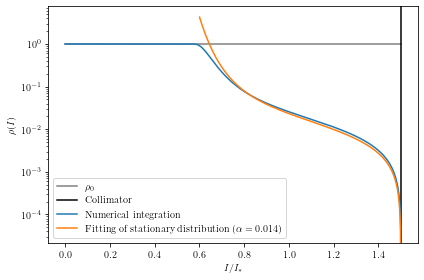

In [14]:
plt.plot(data1[0][:], np.ones_like(data1[1][:]), c="grey", label="$\\rho_0$")
plt.axvline(1.5, c="black", label="Collimator")

plt.plot(data1[0][:], data1[1][:], label="Numerical integration")
plt.plot(data1[0][idx:], np.array(stat_f(data1[0][idx:], 10**popt_log[0])), label="Fitting of stationary distribution $(\\alpha = {:.2})$".format(10**popt_log[0]))

plt.xlabel("$I/I_\\ast$")
plt.ylabel("$\\rho(I)$")

plt.legend()

plt.yscale("log")
plt.tight_layout()

plt.savefig(os.path.join(PATH+"stationary_distribution.pdf"), dpi=DPI)

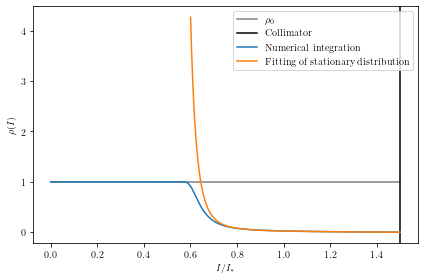

In [15]:
plt.plot(data1[0][:], np.ones_like(data1[1][:]), c="grey", label="$\\rho_0$")
plt.axvline(1.5, c="black", label="Collimator")

plt.plot(data1[0][:], data1[1][:], label="Numerical integration")
plt.plot(data1[0][idx:], np.array(stat_f(data1[0][idx:], 10**popt_log[0])), label="Fitting of stationary distribution")

plt.xlabel("$I/I_\\ast$")
plt.ylabel("$\\rho(I)$")

plt.legend()

#plt.yscale("log")
plt.tight_layout()

#plt.savefig(os.path.join(PATH+"stationary_distribution.pdf"), dpi=DPI)

## Difference in distributions for stationary

In [129]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)

gap = 0.05

In [130]:
I_min = 0.4
I_max = 1.0
c = nt.standard_c(0.0, I_max, I_star, exponent)
sampling = 10000


I = np.linspace(I_min, I_max+gap, sampling)

I0 = nt.stationary_dist(I, I_max, I_star, exponent, c)
I0[I0 < 0] = 0.0

I0_bis = nt.stationary_dist(I, I_max + gap, I_star, exponent, c)

I0_ter = nt.stationary_dist(I, I_max - gap, I_star, exponent, c)
I0_ter[I0_ter < 0] = 0.0

I0 /= I0[0]
I0_bis /= I0_bis[0]
I0_ter /= I0_ter[0]

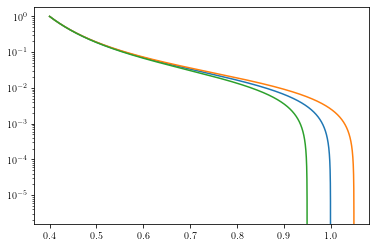

In [131]:
plt.plot(I, I0)
plt.plot(I, I0_bis)
plt.plot(I, I0_ter)
plt.yscale("log")

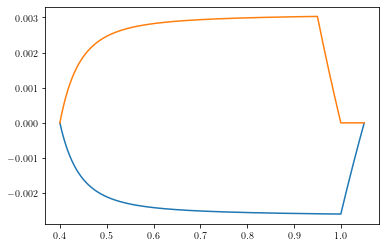

In [132]:
plt.plot(I, I0 - I0_bis)
plt.plot(I, I0 - I0_ter)

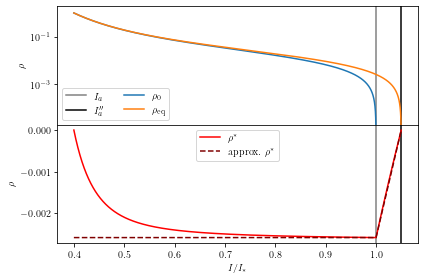

In [133]:
fig = plt.figure()#(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

idx = -1

ax0.axvline(I_max, color="grey", label="$I_a$")
ax0.axvline(I_max + gap, color="black", label="$I''_a$")

ax0.plot(I[:idx], I0[:idx], label="$\\rho_0$")
ax0.plot(I[:idx], I0_bis[:idx], label="$\\rho_\\text{eq}$")
ax0.set_yscale("log")

ax0.legend(ncol=2)
ax0.set_ylim(bottom=0.2e-4)

ax1.axvline(I_max, color="grey")
ax1.axvline(I_max + gap, color="black")

idx2 = np.argmax(I>I_max)

ax1.plot(I[:idx], - I0_bis[:idx] + I0[:idx], color="red", label="$\\rho^*$")

block1 = np.ones_like(I[:idx2]) * (- I0_bis[:idx] + I0[:idx])[idx2]
block2 = np.linspace((- I0_bis[:idx] + I0[:idx])[idx2], 0.0, len(I) - idx2)

ax1.plot(I, np.concatenate((block1, block2)), "--", color="maroon", label="approx. $\\rho^*$")

ax1.legend()

ax1.set_xlabel("$I / I_\\ast$")
ax0.set_ylabel("$\\rho$")
ax1.set_ylabel("$\\rho$")

plt.tight_layout()

plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"difference_outwards.pdf"), dpi=DPI)

### Currents...

In [136]:
c = nt.standard_c(0.0, I_max+gap, I_star, exponent)
engine = cn.cn_generic(I_min, I_max+gap, I0[:], 0.000001, lambda x : nt.D(x, I_star, exponent, c, True), False)
engine.lock_left()

In [137]:
data = engine.current(10000, 2, False)

100%|██████████| 10000/10000 [00:03<00:00, 3143.90it/s]


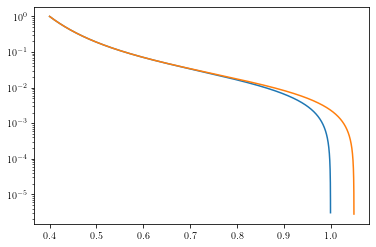

In [138]:
plt.plot(I[:idx2], I0[:idx2])
coso = engine.get_data_with_x()
plt.plot(coso[0], coso[1])
plt.yscale("log")

In [150]:
times_array = np.linspace(data[0][1], data[0][-1], 100)
rho = scipy.interpolate.interp1d(I, - I0_bis[:] + I0[:], kind='cubic')
current = nt.current_generic(times_array, rho, I[:idx][-1], I_min, I_star, exponent, c)

rho = scipy.interpolate.interp1d(I, np.concatenate((block1, block2)), kind='cubic')
current_approx = nt.current_generic(times_array, rho, I[:idx][-1], I_min, I_star, exponent, c)

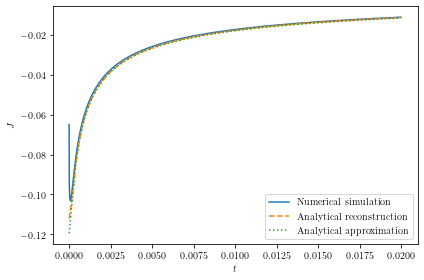

In [153]:
plt.plot(data[0], data[1], label="Numerical simulation")
plt.plot(times_array, current, "--", label="Analytical reconstruction")
plt.plot(times_array, current_approx, linestyle="dotted", label="Analytical approximation")
#plt.yscale("log")

plt.xlabel("$t$")
plt.ylabel("$J$")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(PATH+"current_outwards.pdf"), dpi=DPI)

### And now the other one

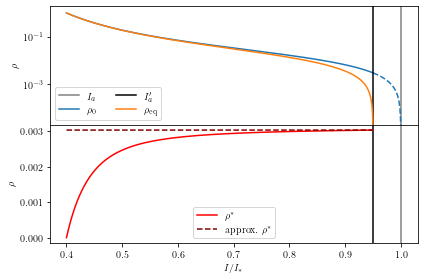

In [154]:
fig = plt.figure()#(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

idx = np.argmax(I>I_max)
idx2 = np.argmax(I>I_max-gap)

ax0.axvline(I_max, color="grey", label="$I_a$")

ax0.plot(I[:idx2], I0[:idx2], label="$\\rho_0$")
ax0.plot(I[idx2:idx], I0[idx2:idx], "--", c="C0")
ax0.axvline(I_max - gap, color="black", label="$I'_a$")
ax0.plot(I[:idx], I0_ter[:idx], label="$\\rho_\\text{eq}$")
ax0.set_yscale("log")

ax0.legend(ncol=2)
ax0.set_ylim(bottom=0.2e-4)

ax1.axvline(I_max, color="grey")
ax1.axvline(I_max - gap, color="black")

idx = np.argmax(I>I_max-gap)

ax1.plot(I[:idx], - I0_ter[:idx] + I0[:idx], color="red", label="$\\rho^*$")
ax1.plot(I[:idx], np.ones_like(I[:idx]) * (- I0_ter[:idx] + I0[:idx])[-1], "--", color="maroon", label="approx. $\\rho^*$")
ax1.legend()

ax1.set_xlabel("$I / I_\\ast$")
ax0.set_ylabel("$\\rho$")
ax1.set_ylabel("$\\rho$")

plt.tight_layout()

plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"difference_backwards.pdf"), dpi=DPI)

### Currents...

In [155]:
c = nt.standard_c(0.0, I_max-gap, I_star, exponent)
engine = cn.cn_generic(I_min, I_max-gap, I0[:idx2], 0.000001, lambda x : nt.D(x, I_star, exponent, c, True), False)
engine.lock_left()

In [156]:
data = engine.current(10000, 2, False)

100%|██████████| 10000/10000 [00:02<00:00, 3469.88it/s]


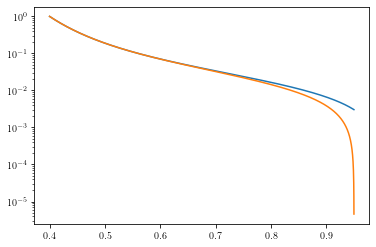

In [157]:
plt.plot(I[:idx2], I0[:idx2])
coso = engine.get_data_with_x()
plt.plot(coso[0], coso[1])
plt.yscale("log")

In [158]:
times_array = np.linspace(data[0][1], data[0][-1], 200)
rho = scipy.interpolate.interp1d(I[:idx2], I0[:idx2] - I0_ter[:idx2], kind='cubic')
current = nt.current_generic(times_array, rho, I[:idx2][-1], I_min, I_star, exponent, c)

current_approx = nt.current_generic(times_array, lambda x : rho(I[:idx2][-1]), I[:idx2][-1], I_min, I_star, exponent, c)

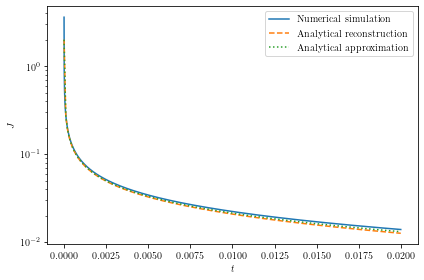

In [160]:
plt.plot(data[0], data[1], label="Numerical simulation")
plt.plot(times_array, current, "--", label="Analytical reconstruction")
plt.plot(times_array, current_approx, linestyle="dotted", label="Analytical approximation")
plt.yscale("log")

plt.xlabel("$t$")
plt.ylabel("$J$")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(PATH+"current_backwards.pdf"), dpi=DPI)

## Comparison between the recovery currents

In [22]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)

gap = 0.05

I_min = 0.0
I_max = 1.0
c = nt.standard_c(0.0, I_max, I_star, exponent)
sampling = 10000

I = np.linspace(0.0, I_max, sampling)
I0 = np.exp(-I)

cn_time_steps = 10000
dt = nt.afpt(I_max, I_max + gap, I_star, exponent, c) / cn_time_steps

In [23]:
dt

1.8984591713252536e-06

In [24]:
engine = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

engine_out = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)


engine_in = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


In [25]:
data_0 = engine.current(4000, 2, False)

engine.reset()
data_0_bis = engine.current(1000, 2, False)
data_0_ter = engine.current(3000, 2, False)

data_1 = engine_out.current(1000, 2, False)
engine_out.move_barrier_forward(gap)
data_2 = engine_out.current(3000, 2, False)


data_3 = engine_in.current(1000, 2, False)
engine_in.move_barrier_backward(gap)
data_4 = engine_in.current(3000, 2, False)

100%|██████████| 1000/1000 [00:00<00:00, 3095.44it/s]
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
100%|██████████| 3000/3000 [00:00<00:00, 3270.02it/s]


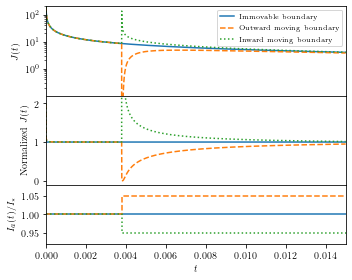

In [26]:
fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 3, 2])

ax0 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax0)
ax1 = plt.subplot(gs[2], sharex=ax0)

ax0.plot(
    data_0[0],
    data_0[1],
    label="Immovable boundary"
)
ax0.plot(
    np.concatenate((data_1[0], data_2[0])),
    np.concatenate((data_1[1], data_2[1])),
    "--",
    label="Outward moving boundary"
)
ax0.plot(
    np.concatenate((data_1[0], data_4[0])),
    np.concatenate((data_1[1], data_4[1])),
    linestyle="dotted",
    label="Inward moving boundary"
)

ax2.plot(
    data_0[0],
    data_0[1]/data_0[1],
    label="Immovable boundary"
)
ax2.plot(
    np.concatenate((data_1[0], data_2[0])),
    np.concatenate((data_1[1]/data_0_bis[1], data_2[1]/data_0_ter[1])),
    "--",
    label="Outward moving boundary"
)
ax2.plot(
    np.concatenate((data_1[0], data_4[0])),
    np.concatenate((data_1[1]/data_0_bis[1], data_4[1]/data_0_ter[1])),
    linestyle="dotted",
    label="Inward moving boundary"
)


ax0.legend(fontsize="x-small")

ax0.set_yscale("log")
ax0.set_ylim(1.01e-1, 2e2)
ax0.set_xlim(0, 0.015)

ax1.axhline(1.0, c="C0")
ax1.plot([0.0, data_1[0][-1], data_1[0][-1], 0.015], [1.0, 1.0, 1.05, 1.05], "--", c="C1")
ax1.plot([0.0, data_1[0][-1], data_1[0][-1], 0.015], [1.0, 1.0, 0.95, 0.95], linestyle="dotted", c="C2")
ax1.set_ylim(0.92, 1.08)
ax2.set_ylim(-0.1, 2.2)


ax0.set_ylabel("$J(t)$")
ax2.set_ylabel("Normalized $J(t)$")
ax1.set_xlabel("$t$")
ax1.set_ylabel("$I_a(t) / I_\\ast$")

plt.tight_layout()

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"global_vs_moving_current.pdf"), dpi=DPI)

## The Protocol

In [27]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)

gap = 0.02

I_min = 0.0
I_max = 1.0
c = nt.standard_c(0.0, I_max, I_star, exponent)
sampling = 10000

I = np.linspace(0.0, I_max, sampling)
I0 = np.exp(-I)

cn_time_steps = 10000
dt = nt.afpt(I_max, I_max + gap, I_star, exponent, c) / cn_time_steps

In [28]:
engine = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

engine_immovable = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


In [29]:
steps = 5000
big_steps = 3000

times = []
collimators = []

data = []
data_immovable = []

times.append(0.0)
collimators.append(I_max)

data.append(engine.current(steps, 2, False))
data_immovable.append(engine_immovable.current(steps, 2, False))

times.append(data[-1][0][-1])
collimators.append(I_max)

for i in tqdm(range(3)):
    engine.move_barrier_forward(gap)
    
    times.append(data[-1][0][-1])
    collimators.append(I_max + gap)
    
    data.append(engine.current(big_steps, 2, False))
    
    times.append(data[-1][0][-1])
    collimators.append(I_max + gap)
    
    engine.move_barrier_backward(gap)
    
    times.append(data[-1][0][-1])
    collimators.append(I_max)
    
    data.append(engine.current(big_steps, 2, False))
    
    times.append(data[-1][0][-1])
    collimators.append(I_max)
    
    data_immovable.append(engine_immovable.current(big_steps, 2, False))
    data_immovable.append(engine_immovable.current(big_steps, 2, False))
    
engine.move_barrier_forward(gap)

times.append(data[-1][0][-1])
collimators.append(I_max + gap)

data.append(engine.current(big_steps, 2, False))
data_immovable.append(engine_immovable.current(big_steps, 2, False))

times.append(data[-1][0][-1])
collimators.append(I_max + gap)

engine.move_barrier_forward(gap)

times.append(data[-1][0][-1])
collimators.append(I_max + gap * 2)

data.append(engine.current(big_steps, 2, False))
data_immovable.append(engine_immovable.current(big_steps, 2, False))

times.append(data[-1][0][-1])
collimators.append(I_max + gap * 2)

100%|██████████| 5000/5000 [00:01<00:00, 3069.52it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████| 3000/3000 [00:01<00:00, 2974.07it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3082.48it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3073.00it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3090.51it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3051.07it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3062.05it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3096.14it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3092.39it/s]

100%|██████████| 3000/3000 [00:01<00:00, 2988.04it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3077.43it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3116.40it/s]

100%|██████████| 3000/3000 [00:00<00:00, 3120.83it/s]


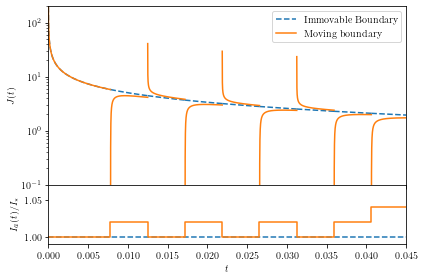

In [30]:
fig = plt.figure()
#fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

for i, d in enumerate(data_immovable):
    if i == 0:
        ax0.plot(d[0], d[1], "--", c="C0", label="Immovable Boundary")
    else:
        ax0.plot(d[0], d[1], "--", c="C0")
for i, d in enumerate(data):
    if i == 0:
        ax0.plot(d[0], d[1], c="C1", label="Moving boundary")
    else:
        ax0.plot(d[0], d[1], c="C1")
        
ax0.set_yscale("log")
ax0.set_ylim(1e-1, 2e2)
ax0.set_xlim(0, 0.045)

ax0.legend()

ax1.plot(times, np.ones_like(collimators), "--")
ax1.plot(times, collimators)
ax1.set_ylim(0.99, 1.07)

ax0.set_ylabel("$J(t)$")
ax1.set_xlabel("$t$")
ax1.set_ylabel("$I_a(t) / I_\\ast$")

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"the_protocol.pdf"), dpi=DPI)

## Normalization (with previous data)

In [31]:
data_imm = data_immovable[:-1]
data_mov = data[1:-1]
data_up = [data[2], data[4], data[6]]
data_down = [data[1], data[3], data[5], data[7]]

time_up = [data[0][0][-1]]
current_up = [data[0][1][-1]]
time_down = [data[0][0][-1]]
current_down = [data[0][1][-1]]

for d in data_up:
    time_up.append(d[0][-1])
    current_up.append(d[1][-1])
time_up.append(data_mov[-1][0][-1])
current_up.append(data_mov[-1][1][-1])

for d in data_down:
    time_down.append(d[0][-1])
    current_down.append(d[1][-1])

In [32]:
samples = np.linspace(time_up[0], time_up[-1], 1000)

f_up = scipy.interpolate.interp1d(time_up, current_up, kind="cubic")
f_down = scipy.interpolate.interp1d(time_down, current_down, kind="cubic")
def f_mid(x):
    return (f_up(x) + f_down(x)) / 2.0

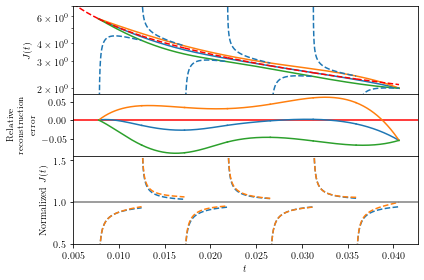

In [36]:
fig = plt.figure()
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.7, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)


ax0.plot(samples, f_mid(samples))
ax0.plot(samples, f_up(samples))
ax0.plot(samples, f_down(samples))

for i, d in enumerate(data_mov):
    if i == 0:
        ax0.plot(d[0], d[1], "--", c="C0", label="")
    else:
        ax0.plot(d[0], d[1], "--", c="C0")

for i, d in enumerate(data_imm):
    ax0.plot(d[0], d[1], "--", c="red")
        
ax0.set_yscale("log")
ax0.set_ylim(0.180e1, 0.7e1)
ax0.set_xlim(0.005)        

ax1.axhline(0.0, c="red")
for i, d in enumerate(data_imm[1:]):
    ax1.plot(d[0], (f_mid(d[0]) - d[1]) / d[1], c="C0")
    ax1.plot(d[0], (f_up(d[0]) - d[1]) / d[1], c="C1")
    ax1.plot(d[0], (f_down(d[0]) - d[1]) / d[1], c="C2")
#ax1.set_ylim(0.88, 1.12)
    
for i, d in enumerate(data_mov):
    if i == 0:
        ax2.plot(d[0], d[1] / data_imm[i+1][1], "--", c="C0", label="")
        ax2.plot(d[0], d[1] / f_mid(d[0]), "--", c="C1", label="")
    else:
        ax2.plot(d[0], d[1] / data_imm[i+1][1], "--", c="C0")
        ax2.plot(d[0], d[1] / f_mid(d[0]), "--", c="C1")
ax2.axhline(1.0, c="grey")
ax2.set_ylim(0.5, 1.55)

ax2.set_xlabel("$t$")
ax0.set_ylabel("$J(t)$")
ax1.set_ylabel("\\small{Relative}\n\\small{reconstruction}"+"\n"+"\small{error}")
ax2.set_ylabel("Normalized $J(t)$")

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"the_interpolation.pdf"), dpi=DPI)

# EXTRACTING THE DATA FROM THE DICTIONARY

In [22]:
%matplotlib inline

In [39]:
import pickle

In [40]:
DATA_PATH = "/home/camontan/moving_barrier_data"

In [41]:
with open(os.path.join(DATA_PATH, 'processed_evolution_tiptap_only.pkl'), 'rb') as f:
    d = pickle.load(f)

In [42]:
mov = "the_steady_tip-tap_standard"

In [43]:
pos = []
rep = []
magic = []
pos_list = []
rep_list = []
magic_list = []

for i, p in enumerate(d[mov]):
    if i==0:
        for j, r in enumerate(d[mov][p]):
            if j==0:
                for k, m in enumerate(d[mov][p][r]):
                    magic.append(m)
                    magic_list.append(m)
            rep.append(r)
            rep_list.append(r)
    pos.append(p)
    pos_list.append(p)

In [44]:
pos

['avg', 'high', 'higher', 'low', 'lowlow', 'mid', 'over', 'same', 'ultra']

In [45]:
I_max_list = {
    p : d[mov][p][rep[1]]["main_info"]["I_max"] / d[mov][p][rep[1]]["main_info"]["I_star"]
    for p in pos
}

In [46]:
rep

['10', '1', '20', '2', '4', '50', '5']

In [47]:
I_max_list

{'avg': 0.3,
 'high': 0.75,
 'higher': 0.9,
 'low': 0.2,
 'lowlow': 0.1,
 'mid': 0.5,
 'over': 1.75,
 'same': 1.0,
 'ultra': 1.25}

In [48]:
magic

['main_info',
 'high_standard',
 'high_true',
 'high_true-delta',
 'high_true+delta',
 'low_standard',
 'low_true',
 'low_true-delta',
 'low_true+delta']

## Best ideal magic numbers

In [49]:
magic_data_high = {}
magic_data_low = {}

for r in rep:
    magic_data_high[r] = [[], []]
    magic_data_low[r] = [[], []]
    for p in I_max_list:
        magic_data_high[r][0].append(I_max_list[p])
        magic_data_high[r][1].append(float(d[mov][p][r]['high_true']['processed']["magic"]))
        magic_data_low[r][0].append(I_max_list[p])
        magic_data_low[r][1].append(float(d[mov][p][r]['low_true']['processed']["magic"]))
        

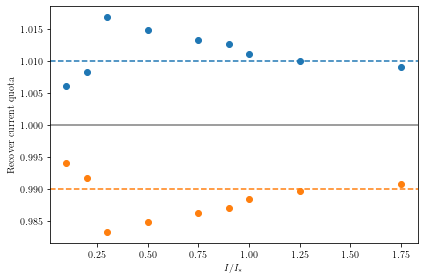

In [50]:
r = '5'
plt.scatter(magic_data_high[r][0], magic_data_high[r][1])
plt.scatter(magic_data_low[r][0], magic_data_low[r][1])

plt.axhline(1.0, c="grey")
plt.axhline(1.01, linestyle="dashed", c="C0")
plt.axhline(0.99, linestyle="dashed", c="C1")

plt.xlabel("$I/I_\\ast$")
plt.ylabel("Recover current quota")

plt.tight_layout()
plt.savefig(os.path.join(PATH+"magic_numbers.pdf"), dpi=DPI)

In [52]:
data = d[mov][pos][r]["main_info"]

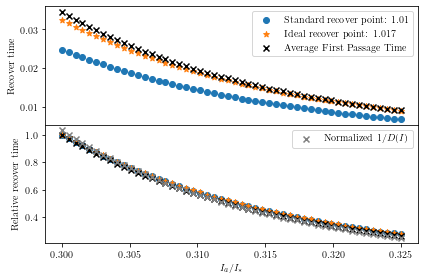

In [53]:
r = '5'
pos = 'avg'
post = 'processed'
I_star = d[mov][pos][r]["main_info"]["I_star"]

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

axs = plt.subplot(gs[0])
axs1 = plt.subplot(gs[1], sharex=axs)

x = (d[mov][pos][r][m][post]["val"])
y_standard = (d[mov][pos][r]['high_standard'][post]["avg"])
y_ideal = (d[mov][pos][r]['high_true'][post]["avg"])

y_afpt = (d[mov][pos][r][m][post]["afpt"])

#### OKKIO QUA!!!! ###
axs.scatter(x / I_star, y_standard, label="Standard recover point: {:.4}".format(float(d[mov][pos][r]['high_standard'][post]["magic"]) - 0.01))
axs.scatter(x / I_star, y_ideal, marker="*", label="Ideal recover point: {:.4}".format(float(d[mov][pos][r]['high_true'][post]["magic"])))
axs.scatter(x / I_star, y_afpt, label="Average First Passage Time", marker="x", color="black")

axs1.scatter(x / I_star, y_standard / y_standard[0])
axs1.scatter(x / I_star, y_ideal / y_ideal[0], marker="*")
axs1.scatter(x / I_star, y_afpt / y_afpt[0], marker="x", color="black")

y_test = np.array([nt.D(x[i], data["I_star"], data["exponent"], data["c"]) for i in range(len(x))])
y_test = 1/y_test
axs1.scatter(x / I_star, y_test / y_test[1], marker="x", color="grey", label="Normalized $1/D(I)$")
######################

axs.legend()
axs1.legend()
axs.set_ylabel("Recover time")
axs1.set_ylabel("Relative recover time")
axs1.set_xlabel("$I_a / I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)

plt.savefig(os.path.join(PATH+"recover_times.pdf"), dpi=DPI)

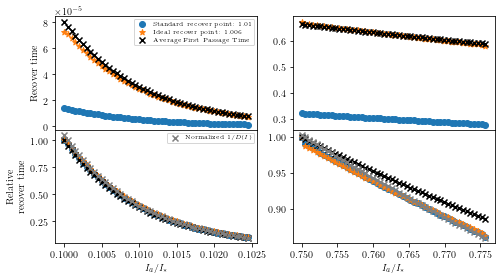

In [54]:
fig = plt.figure(figsize=(7,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

axs = plt.subplot(gs[0])
axs1 = plt.subplot(gs[2], sharex=axs)

axs2 = plt.subplot(gs[1])
axs3 = plt.subplot(gs[3], sharex=axs2)

r = '5'
pos = 'lowlow'
post = 'processed'
I_star = d[mov][pos][r]["main_info"]["I_star"]

x = (d[mov][pos][r][m][post]["val"])
y_standard = (d[mov][pos][r]['high_standard'][post]["avg"])
y_ideal = (d[mov][pos][r]['high_true'][post]["avg"])

y_afpt = (d[mov][pos][r][m][post]["afpt"])

#### OKKIO QUA!!!! ###
axs.scatter(x / I_star, y_standard, label="Standard recover point: {:.4}".format(float(d[mov][pos][r]['high_standard'][post]["magic"]) - 0.01))
axs.scatter(x / I_star, y_ideal, marker="*", label="Ideal recover point: {:.4}".format(float(d[mov][pos][r]['high_true'][post]["magic"])))
axs.scatter(x / I_star, y_afpt, label="Average First Passage Time", marker="x", color="black")

axs1.scatter(x / I_star, y_standard / y_standard[0])
axs1.scatter(x / I_star, y_ideal / y_ideal[0], marker="*")
axs1.scatter(x / I_star, y_afpt / y_afpt[0], marker="x", color="black")

y_test = np.array([nt.D(x[i], data["I_star"], data["exponent"], data["c"]) for i in range(len(x))])
y_test = 1/y_test
axs1.scatter(x / I_star, y_test / y_test[1], marker="x", color="grey", label="Normalized $1/D(I)$")
######################

r = '5'
pos = 'high'
post = 'processed'
I_star = d[mov][pos][r]["main_info"]["I_star"]

x = (d[mov][pos][r][m][post]["val"])
y_standard = (d[mov][pos][r]['high_standard'][post]["avg"])
y_ideal = (d[mov][pos][r]['high_true'][post]["avg"])

y_afpt = (d[mov][pos][r][m][post]["afpt"])

#### OKKIO QUA!!!! ###
axs2.scatter(x / I_star, y_standard, label="Standard recover point: {:.4}".format(float(d[mov][pos][r]['high_standard'][post]["magic"]) - 0.01))
axs2.scatter(x / I_star, y_ideal, marker="*", label="Ideal recover point: {:.4}".format(float(d[mov][pos][r]['high_true'][post]["magic"])))
axs2.scatter(x / I_star, y_afpt, label="Average First Passage Time", marker="x", color="black")

axs3.scatter(x / I_star, y_standard / y_standard[0])
axs3.scatter(x / I_star, y_ideal / y_ideal[0], marker="*")
axs3.scatter(x / I_star, y_afpt / y_afpt[0], marker="x", color="black")

y_test = np.array([nt.D(x[i], data["I_star"], data["exponent"], data["c"]) for i in range(len(x))])
y_test = 1/y_test
axs3.scatter(x / I_star, y_test / y_test[1], marker="x", color="grey", label="Normalized $1/D(I)$")
######################

axs.legend(fontsize="xx-small")
axs1.legend(fontsize="xx-small")
axs.set_ylabel("Recover time")
axs1.set_ylabel("Relative\nrecover time")
axs1.set_xlabel("$I_a / I_*$")
axs3.set_xlabel("$I_a / I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(wspace=.0)
plt.setp(axs.get_xticklabels(), visible=False)
plt.setp(axs2.get_xticklabels(), visible=False)
#plt.setp(axs2.get_yticklabels(), visible=False)
#plt.setp(axs3.get_yticklabels(), visible=False)
plt.savefig(os.path.join(PATH+"recover_times_multiple.pdf"), dpi=DPI)

# Fit Results

In [301]:
rep = '5'
pos = 'lowlow'
post = 'processed'

In [302]:
data = d[mov][pos][rep]["main_info"]

In [303]:
params = lmfit.Parameters()
params.add("I_star", data["I_star"], min=0.0)
params.add("exponent", data["exponent"], min=0.0)
params.add("c", data["c"], vary=False)

In [327]:
def resid(params, xdata, ydata):
    I_star = params["I_star"]
    exponent = params["exponent"]
    c = params["c"]
    I_low = [x[0] for x in xdata]
    I_high = [x[1] for x in xdata]
    afpt = np.array([
        nt.afpt(
            I_low[i],
            I_high[i],
            I_star,
            exponent,
            c
    ) for i in range(len(I_low))])
    if np.any(np.isnan(afpt)) or np.any(np.isinf(afpt)):
        print("BAD STUFF!")
        return np.ones_like(ydata) * 1e6
    return afpt - ydata

In [328]:
mov = 'the_steady_tip-tap_standard'
rep = '10'
post = 'processed'

In [334]:
x_vals = []

kappa_standard = []
kappa_ideal = []

I_star_standard = []
I_star_ideal = []

for p in tqdm(pos_list):
    x_vals.append(I_max_list[p])

    data = d[mov][p][rep]["main_info"]
    sample = d[mov][p][rep]["high_true"][post]
    sample_standard = d[mov][p][rep]["high_standard"][post]

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_ideal = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample["val"] - data["step_size"],
                sample["val"]
            )),
            sample["avg"]
        ),
        method="leastsq"
    )
    kappa_ideal.append(fit_data_ideal.params["exponent"].value)
    I_star_ideal.append(fit_data_ideal.params["I_star"].value)

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_standard = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample_standard["val"] - data["step_size"],
                sample_standard["val"]
            )),
            sample_standard["avg"]
        ),
        method="leastsq"
    )
    kappa_standard.append(fit_data_standard.params["exponent"].value)
    I_star_standard.append(fit_data_standard.params["I_star"].value)

    
kappa_standard = 1 / np.asarray(kappa_standard) / 2
kappa_ideal = 1 / np.asarray(kappa_ideal) / 2

I_star_standard = np.asarray(I_star_standard)
I_star_ideal = np.asarray(I_star_ideal)


  0%|          | 0/9 [00:00<?, ?it/s]

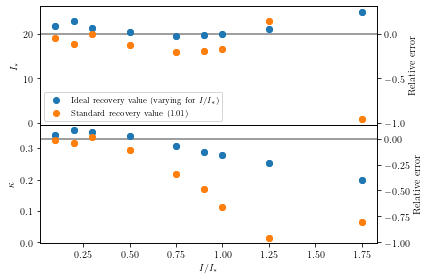

In [335]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1_bis = ax1.twinx()
ax2_bis = ax2.twinx()

ax1.scatter(x_vals, I_star_ideal, label='Ideal recovery value (varying for $I/I_\\ast$)')
ax1_bis.scatter(x_vals, (I_star_ideal-data["I_star"])/data["I_star"])
ax1.scatter(x_vals, I_star_standard, label="Standard recovery value (1.01)")
ax1_bis.scatter(x_vals, (I_star_standard-data["I_star"])/data["I_star"], label="")

ax1.legend(fontsize="small")
ax1.axhline(data["I_star"], color="grey")
ax1.set_ylabel("$I_*$")
ax1_bis.set_ylabel("Relative error")

ax2.scatter(x_vals, kappa_ideal)
ax2.scatter(x_vals, kappa_standard)
ax2_bis.scatter(x_vals, (kappa_ideal-data["k"])/data["k"])
ax2_bis.scatter(x_vals, (kappa_standard-data["k"])/data["k"])

ax2.axhline(data["k"], color="grey")
ax2.set_ylabel("$\\kappa$")
ax2_bis.set_ylabel("Relative error")
ax2.set_xlabel("$I/I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)

plt.savefig(os.path.join(PATH+"high_fits.pdf"), dpi=DPI)

In [331]:
x_vals = []

kappa_standard = []
kappa_ideal = []

I_star_standard = []
I_star_ideal = []

for p in tqdm(pos_list):
    x_vals.append(I_max_list[p])

    data = d[mov][p][rep]["main_info"]
    sample = d[mov][p][rep]["low_true"][post]
    sample_standard = d[mov][p][rep]["low_standard"][post]

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_ideal = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample["val"],
                sample["val"] + data["step_size"]
            )),
            sample["avg"]
        ),
        method="leastsq"
    )
    kappa_ideal.append(fit_data_ideal.params["exponent"].value)
    I_star_ideal.append(fit_data_ideal.params["I_star"].value)

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_standard = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample_standard["val"],
                sample_standard["val"] + data["step_size"]
            )),
            sample_standard["avg"]
        ),
        method="leastsq"
    )
    kappa_standard.append(fit_data_standard.params["exponent"].value)
    I_star_standard.append(fit_data_standard.params["I_star"].value)

kappa_standard = 1 / np.asarray(kappa_standard) / 2
kappa_ideal = 1 / np.asarray(kappa_ideal) / 2

I_star_standard = np.asarray(I_star_standard)
I_star_ideal = np.asarray(I_star_ideal)


  0%|          | 0/9 [00:00<?, ?it/s]

### Plot (Low)

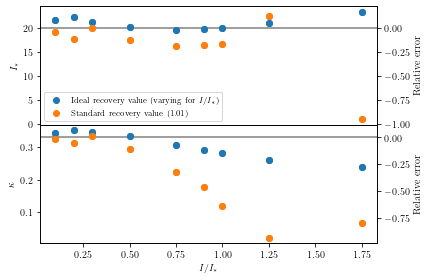

In [333]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1_bis = ax1.twinx()
ax2_bis = ax2.twinx()

ax1.scatter(x_vals, I_star_ideal, label='Ideal recovery value (varying for $I/I_\\ast$)')
ax1_bis.scatter(x_vals, (I_star_ideal-data["I_star"])/data["I_star"])
ax1.scatter(x_vals, I_star_standard, label="Standard recovery value (1.01)")
ax1_bis.scatter(x_vals, (I_star_standard-data["I_star"])/data["I_star"], label="")

ax1.legend(fontsize="small")
ax1.axhline(data["I_star"], color="grey")
ax1.set_ylabel("$I_*$")
ax1_bis.set_ylabel("Relative error")

ax2.scatter(x_vals, kappa_ideal)
ax2.scatter(x_vals, kappa_standard)
ax2_bis.scatter(x_vals, (kappa_ideal-data["k"])/data["k"])
ax2_bis.scatter(x_vals, (kappa_standard-data["k"])/data["k"])

ax2.axhline(data["k"], color="grey")
ax2.set_ylabel("$\\kappa$")
ax2_bis.set_ylabel("Relative error")
ax2.set_xlabel("$I/I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)

plt.savefig(os.path.join(PATH+"low_fits.pdf"), dpi=DPI)

# Schema

In [9]:
with open(os.path.join(DATA_PATH, "data_mid_I_a_3_r_5_the_steady_tip-tap_standard.pkl"), 'rb') as f:
    all_data = pickle.load(f)

In [10]:
all_data[2][0].keys()

dict_keys(['I_max_before', 'I_max_high', 'I_max_after', 'I_max_low', 't_absolute', 't_relative', 'current'])

  0%|          | 0/110 [00:00<?, ?it/s]

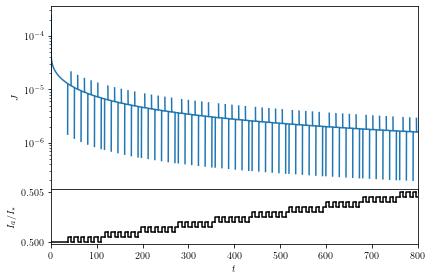

In [20]:
fig = plt.figure()#(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.3])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

for d in tqdm(all_data[2][:len(all_data[2])//5]):
    ax1.plot(
        [d["t_absolute"][0], d["t_absolute"][0], d["t_absolute"][-1]],
        np.asarray([d["I_max_before"], d["I_max_after"], d["I_max_after"]])/all_data[0]["I_star"], c="black")
    ax0.plot(d["t_absolute"], d["current"], c="C0")
ax0.set_yscale("log")

ax1.set_xlabel("$t$")
ax0.set_ylabel("$J$")
ax1.set_ylabel("$I_a/I_\\ast$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.set_xlim(0, 800)

plt.savefig(os.path.join(PATH+"raw_process.pdf"), dpi=DPI)

In [18]:
plt.close("all")

# MULTPLE CURVES

In [184]:
%matplotlib widget

In [171]:
d.keys()

dict_keys(['the_steady_tip-tap_standard'])

In [172]:
mov = "the_steady_tip-tap_standard"
pos = "avg"
rep = "5"

In [173]:
data = d[mov][pos][rep]["main_info"]

In [174]:
multiple_data_file_low = "data_{}_I_a_3_r_{}_the_steady_tip-tap_standard_low_avg.pkl".format(pos, rep)
multiple_data_file_high = "data_{}_I_a_3_r_{}_the_steady_tip-tap_standard_high_avg.pkl".format(pos, rep)

In [175]:
with open(os.path.join(DATA_PATH, multiple_data_file_low), 'rb') as f:
    d_low = pickle.load(f)

with open(os.path.join(DATA_PATH, multiple_data_file_high), 'rb') as f:
    d_high = pickle.load(f)

In [182]:
d_low[list(d_low.keys())[1]].keys()#['mid'].keys()

dict_keys(['mid', 'high', 'low', 'true', 'time'])

In [185]:
plt.figure()

cmap = matplotlib.cm.get_cmap('viridis')
for i, key in list(enumerate(d_high)):
    idx = i / len(d_high)
    plt.plot(d_high[key]['time'], d_high[key]['true']['avg'] - 1.0, c=cmap(idx))

#plt.xscale("log")
plt.yscale("log")
plt.xlim(0, 0.2)
plt.axhline(0.01, c="grey", label="0.01")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Recover current\n[(real current / immovable current) - 1]")

plt.title("Recover current analysis")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Recover current analysis')

# USELESS STUFF

## 3 - Semi-ideal reconstruction

This is the **core experiment** I will discuss most in the paper, so everything must be perfect!

### First, we need to define a realistic initial distribution

It's very simple and direct: if we decide to work in normalized emittance variables, and we work with a gaussian beam distribution with it's characteristic emittance, we have that
$$\rho_0(I) = e^{-I}$$
Where $I$, from now on, is expessed in sigma units.

In [5]:
def rho_0(I, damping_position=np.nan, l=np.nan):
    if np.isnan(damping_position) or np.isnan(l):
        return np.exp(-I)
    else:
        return np.exp(-I) / (1 + np.exp((I - damping_position)/l))

### Setting up the scenario

In [6]:
I_damping = 1.9
I_max = 2.0
I_star = 10.0
k = 0.33
exponent = 1/(2*k)

# As for the time scaling... we go with this one.
# REMEMBER TO SPECIFY IT PROPERLY IN THE PAPER!!!
c = nt.standard_c(0.0, I_max, I_star, exponent)

In [68]:
cn_sampling = 10000
I_list, dI = np.linspace(0.0, I_max, cn_sampling, retstep=True)

cn_time_steps = 100
dt = nt.current_peak_time(I_damping, I_max, I_star, exponent, c)/cn_time_steps

In [69]:
steps_per_sample = 5

steps_per_iteration = 10000
iterations = 10
macro_iterations = 5
long_track_steps = steps_per_iteration * iterations * (macro_iterations + 1)

In [70]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))
data_0 = engine.get_data_with_x()

times_long, current_long = engine.current(long_track_steps, steps_per_sample, False)
data_long = engine.get_data_with_x()

100%|██████████| 600000/600000 [07:24<00:00, 1349.67it/s]


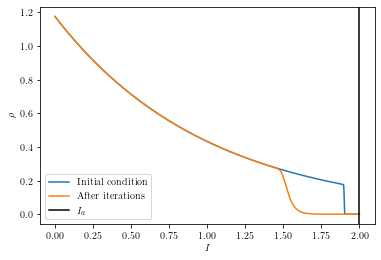

In [71]:
plt.figure()
plt.plot(data_0[0], data_0[1], label="Initial condition")
plt.plot(data_long[0], data_long[1], label="After iterations")
plt.axvline(I_max, color="black", label="$I_a$")
plt.xlabel("$I$")
plt.ylabel("$\\rho$")
plt.legend()

**And here's the current!**

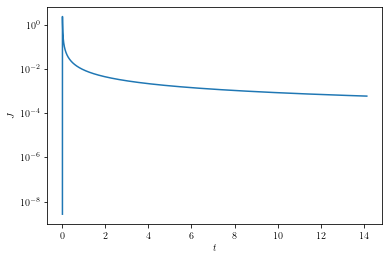

In [72]:
plt.figure()
plt.plot(times_long, current_long)
plt.xlabel("$t$")
plt.ylabel("$J$")
plt.yscale("log")

In [73]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        engine.move_barrier_forward(0.1)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Barrier position')

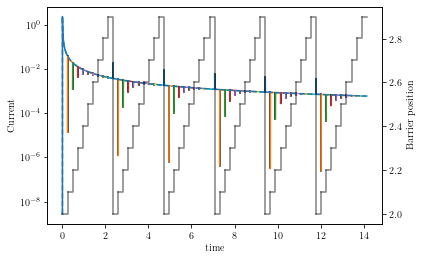

In [74]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

Text(0, 0.5, 'Barrier position')

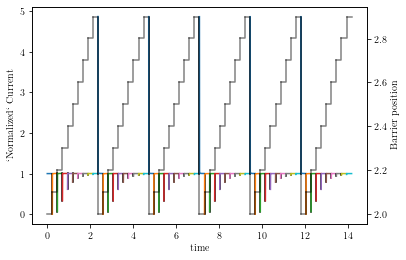

In [75]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

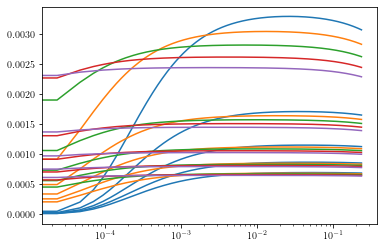

In [76]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1 and i != 1:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%iterations==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%iterations==3 and i != 3:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%iterations==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%iterations==5 and i != 5:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

(0.8, 1.0)

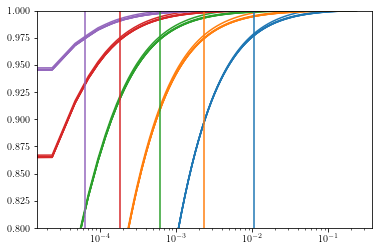

In [77]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%iterations==2:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%iterations==3:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%iterations==4:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%iterations==5:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[1], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[1], I_max_list[2], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[2], I_max_list[3], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[3], I_max_list[4], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[4], I_max_list[5], I_star, exponent, c), c="C4")

plt.xscale("log")
plt.ylim(0.8,1.0)

fit!

In [106]:
def the_func(x_list, I_star, exponent):
    print(I_star, exponent)
    I_start  = [x[0] for x in x_list]
    I_end = [x[1] for x in x_list]
    
    t_list = np.array([afpt(I_start[i], I_end[i], I_star, exponent, c) for i in range(len(I_start))])
    return t_list

In [123]:
selected_times = []
x_list = []

for i in range(len(c_normalized_out)):
    if i%iterations!=0:
        selected_times.append(
            t_absolute_out[0][
                np.argmin(np.absolute(c_normalized_out[i] - 0.96))
            ]
        )
        x_list.append(
            (I_max_list[i-1], I_max_list[i])
        )

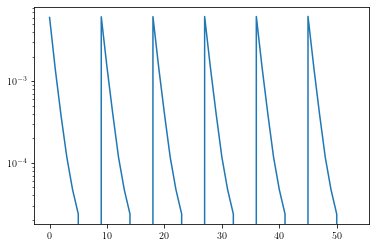

In [124]:
plt.plot(selected_times)
plt.yscale("log")

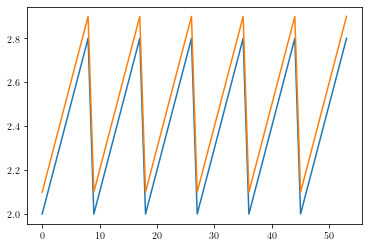

In [125]:
plt.plot(x_list)

In [126]:
popt, pcov = scipy.optimize.curve_fit(
    the_func,
    x_list,
    np.asarray(selected_times),
    p0=(I_star, exponent)
)

10.0 1.5151515151515151
10.0 1.5151515151515151
10.0 1.5151515151515151
10.000000149011612 1.5151515151515151
10.0 1.515151537729032
10.021892109707357 1.5012794933185931
10.021892259045186 1.5012794933185931
10.021892109707357 1.5012795156894008
10.170361389178803 1.483909473782405
10.170361540728997 1.483909473782405
10.170361389178803 1.4839094958943793
10.197209818286442 1.4815041890182439
10.19720997023671 1.4815041890182439
10.197209818286442 1.4815042110943766
10.197085396579315 1.4815225527889655
10.197085548527728 1.4815225527889655
10.197085396579315 1.481522574865372
10.197087579505201 1.4815223548203307


others...

In [ ]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        print(engine.I_max)
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        if i != 0:
            engine.move_barrier_backward(0.1 * i)
            print(engine.I_max)
            
        engine.move_barrier_forward(0.1 * (i+1))
        print(engine.I_max)
        

Text(0, 0.5, 'Barrier position')

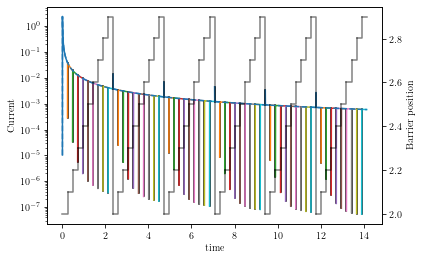

In [28]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

Text(0, 0.5, 'Barrier position')

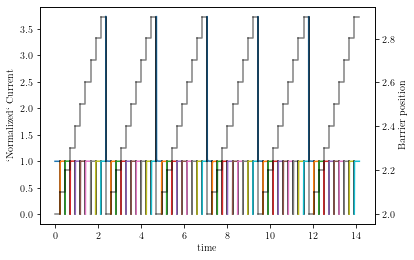

In [29]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

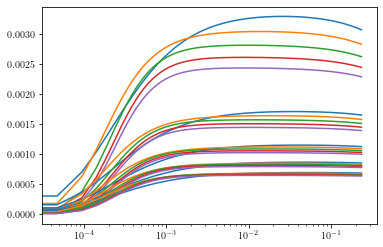

In [30]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1 and i != 1:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%iterations==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%iterations==3 and i != 3:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%iterations==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%iterations==5 and i != 5:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

(0.8, 1.0)

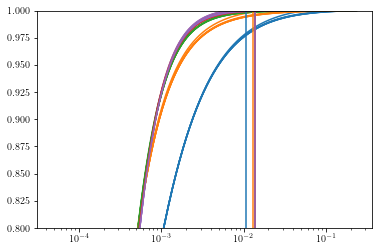

In [32]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%iterations==2:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%iterations==3:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%iterations==4:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%iterations==5:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[1], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[0], I_max_list[2], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[0], I_max_list[3], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[0], I_max_list[4], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[0], I_max_list[5], I_star, exponent, c), c="C4")

plt.xscale("log")
plt.ylim(0.8,1.0)

In [37]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))
data_0 = engine.get_data_with_x()

times_long, current_long = engine.current(long_track_steps*2, steps_per_sample, False)
data_long = engine.get_data_with_x()

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
100%|██████████| 600000/600000 [07:26<00:00, 1343.31it/s]


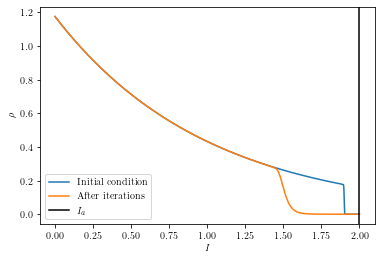

In [38]:
plt.figure()
plt.plot(data_0[0], data_0[1], label="Initial condition")
plt.plot(data_long[0], data_long[1], label="After iterations")
plt.axvline(I_max, color="black", label="$I_a$")
plt.xlabel("$I$")
plt.ylabel("$\\rho$")
plt.legend()

**And here's the current!**

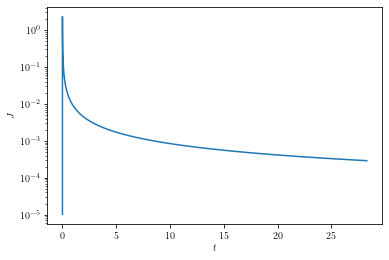

In [39]:
plt.figure()
plt.plot(times_long, current_long)
plt.xlabel("$t$")
plt.ylabel("$J$")
plt.yscale("log")

In [40]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        if i != 0:
            engine.move_barrier_backward(0.1 * i)
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        t_relative_out_partial.append(time)
        t_absolute_out_partial.append(absolute_time)
        c_out_partial.append(current)
        I_max_list_partial.append(engine.I_max)
        set_list_partial.append(i)

            
        engine.move_barrier_forward(0.1 * (i+1))
        

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Barrier position')

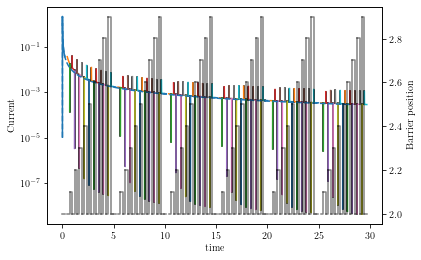

In [44]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

Text(0, 0.5, 'Barrier position')

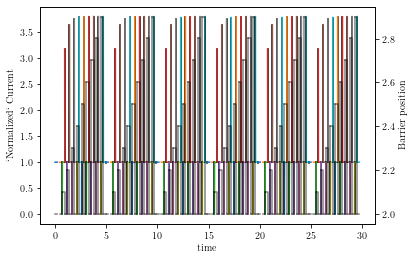

In [45]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

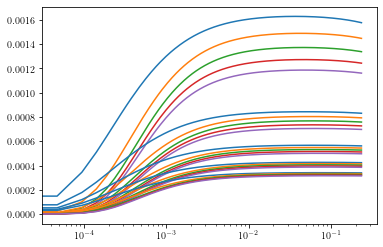

In [50]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%(iterations*2)==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%(iterations*2)==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%(iterations*2)==6 and i != 6:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%(iterations*2)==8 and i != 8:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%(iterations*2)==10 and i != 10:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

(0.005, 0.02)

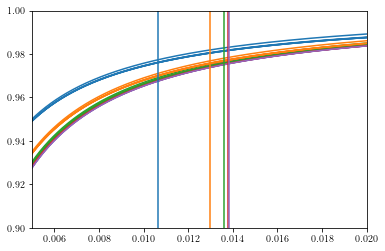

In [62]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%(iterations*2)==2:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%(iterations*2)==4:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%(iterations*2)==6:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%(iterations*2)==8:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%(iterations*2)==10:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[2], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[0], I_max_list[4], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[0], I_max_list[6], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[0], I_max_list[8], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[0], I_max_list[10], I_star, exponent, c), c="C4")

#plt.xscale("log")
plt.ylim(0.9,1.0)
plt.xlim(5e-3, 2e-2)

## 4 - Experimental data